In [20]:
import sys
if '/home/cv/Dropbox/PHD/Python/ESO/spectra_DL' in sys.path:
    sys.path.remove('/home/cv/Dropbox/PHD/Python/ESO/spectra_DL')
sys.path.append('../')
from HARPS_DL.models_structured import decoders_builder, encoders_builder
from HARPS_DL.models_structured.model_infoVAE import info_VAE as infoVAE


In [21]:
import torch
from HARPS_DL.datasets.Labels import Labels

labels = Labels(
            datasets_names=['ETC', 'real'],
            labels=["radvel", "BERV", "Teff", "[M/H]", "logg", "airmass", "H2O_pwv"],
            labels_type = ["shared", "shared", "shared", "shared", "shared", "shared", "ETC"],
            bottleneck=32,
            fill_bottleneck=['ETC'],
            )
labels.json2normalization()

infoVAE_model = infoVAE(
        encoder_name='CNN_classic',
        decoder_name='ResNet_small',
        labels=labels,
        )
model_ckpt = '../selected_models/infoVAE/375-0.108.ckpt'
state_dict = torch.load(model_ckpt, map_location='cpu')['state_dict']
infoVAE_model.load_state_dict(state_dict)

infoVAE_model.eval()

info_VAE(
  (fc_mu): Linear(in_features=10240, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=10240, out_features=32, bias=True)
  (fc_z): Linear(in_features=32, out_features=10240, bias=True)
  (decoder): Decoder(
    (blocks): Sequential(
      (0): PreActTransResNetBlock(
        (net): Sequential(
          (0): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (1): ReLU()
          (2): ConvTranspose1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
          (3): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (4): ReLU()
          (5): ConvTranspose1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
      )
      (1): PreActTransResNetBlock(
        (net): Sequential(
          (0): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (1): ReLU()
          (2): ConvTranspose1d(512, 512, kernel_size=(5,), st

## ETC Spectrum (probably dont include)

Text(0.5, 1.0, '(1, 327680)')

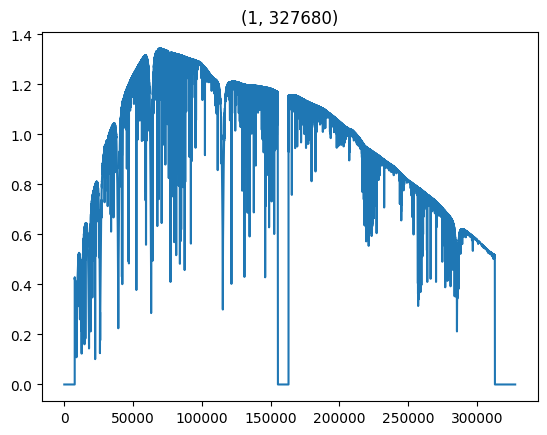

In [22]:
import pickle
from HARPS_DL.generate_simulations.ETC_processing.etc_tools import runtime_fast_2
from matplotlib import pyplot as plt
from HARPS_DL.datasets.Dataset_mixin import Dataset_mixin
import numpy as np

ETC_file = '/media/cv/Elements/ESO/raw_data/ETC_uniform_val/ETC_pickles' + '/0.pickle'
ETC_data = runtime_fast_2(pickle.load(open(ETC_file, 'rb')), rv = 0, debug=False, noise_free=True)

spectrum = ETC_data['S']

spectrum[np.isnan(spectrum)] = 0
spectrum = Dataset_mixin.static_norm_by_median(spectrum, median_threshold=0)
spectrum = np.expand_dims(spectrum, axis=0)
spectrum[Dataset_mixin.get_artifact_mask(1) == 0] = 0

plt.figure()
plt.plot(spectrum.ravel())
plt.title(spectrum.shape)

In [23]:
#spectrum = spectrum.astype(np.float32)
spectrum /= np.median(spectrum)
spectrum = spectrum.reshape(1, 1, -1)
spectrum = torch.tensor(spectrum, dtype=torch.float32)
out = infoVAE_model.forward(spectrum)


Text(0.5, 1.0, 'MAE is 0.03')

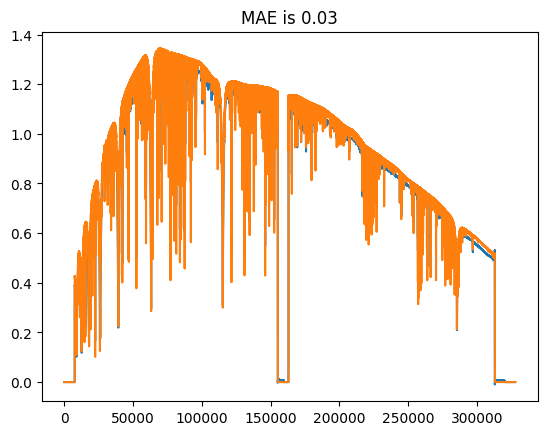

In [24]:
%matplotlib inline
plt.figure()
spec_in = spectrum.numpy().ravel()
spec_out = out[0].detach().numpy().ravel()
spec_out[Dataset_mixin.get_artifact_mask(1).ravel() == 0] = 0
plt.plot(spec_out)
plt.plot(spec_in)
plt.title(f'MAE is {np.mean(np.abs(spec_out - spec_in)):.2f}')

## Real Spectrum

In [25]:
from astropy.io import fits

hdul = fits.open('ADP.2014-10-02T10:02:10.163.fits')
wave = hdul[1].data.field('WAVE').astype(np.float32).ravel() # barycentric
spectrum_fits = hdul[1].data.field('FLUX').astype(np.float32).ravel()
emul_wave = Dataset_mixin.get_wave()

spectrum = np.interp(emul_wave, wave, spectrum_fits)

Text(0.5, 1.0, '(327680,)')

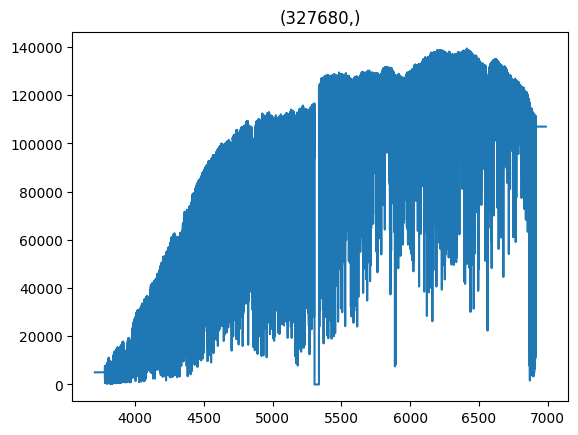

In [26]:
%matplotlib inline
#spectrum = Dataset_mixin.static_norm_by_median(spectrum, median_threshold=0)
plt.figure()
plt.plot(emul_wave, spectrum)
plt.title(spectrum.shape)

In [27]:
spec_in = spectrum.reshape(1, 1, -1)
spec_in = spec_in/np.median(spec_in)
spec_in[:, Dataset_mixin.get_artifact_mask(1) == 0] = 0

spec_in = torch.tensor(spec_in, dtype=torch.float32)
out = infoVAE_model.forward(spec_in)

Text(0.5, 1.0, 'MAE is 0.02')

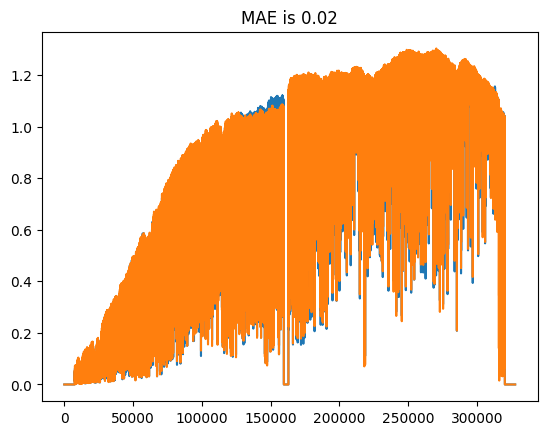

In [28]:
plt.figure()
spec_in_vis = spec_in.numpy().ravel()
spec_out = out[0].detach().numpy().ravel()
labels_out = out[1].detach().numpy()
spec_out[Dataset_mixin.get_artifact_mask(1).ravel() == 0] = 0
plt.plot(spec_out)
plt.plot(spec_in_vis)
plt.title(f'MAE is {np.mean(np.abs(spec_out - spec_in_vis)):.2f}')

## Label Prediction


In [29]:
out, b_predict, _, _ = infoVAE_model.forward(spec_in)

In [30]:
labels.get_vec_length()

7

In [31]:
b_denorm = labels.inverse_normalization_array(b_predict.detach().numpy().T[:7,:])
labels_pred = labels.vec2dics(b_denorm)
display(labels_pred['real'])

{'radvel': array([-23.009708], dtype=float32),
 'BERV': array([9.950475], dtype=float32),
 'Teff': array([5772.4272], dtype=float32),
 '[M/H]': array([0.22216076], dtype=float32),
 'logg': array([4.2692823], dtype=float32),
 'airmass': array([1.2589536], dtype=float32),
 'H2O_pwv': array([6.181073], dtype=float32)}

In [34]:
l_denorm = labels.inverse_normalization_array(labels_out.T[:7,:])
l_gt = labels.vec2dics(l_denorm)
display(l_gt['real'])

{'radvel': array([-23.008286], dtype=float32),
 'BERV': array([9.950952], dtype=float32),
 'Teff': array([5769.353], dtype=float32),
 '[M/H]': array([0.2212347], dtype=float32),
 'logg': array([4.268958], dtype=float32),
 'airmass': array([1.2580478], dtype=float32),
 'H2O_pwv': array([6.0801487], dtype=float32)}

In [33]:
labels_out.shape

(1, 32)

## Sliders